In [2]:
!nvidia-smi

Tue May  4 14:31:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!cp /content/drive/MyDrive/ml/input.zip /content

In [7]:
!unzip "input.zip" -d "./input/"
output.clear()

In [8]:
%cd /content/drive/MyDrive/ml/code

/content/drive/MyDrive/ml/code


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#FCN8s-(VGG-imageNet-weight)" data-toc-modified-id="FCN8s-(VGG-imageNet-weight)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FCN8s (VGG imageNet weight)</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

## requirements/CV2 import를 위한 lib 설치/gpu 및 메모리 상태 확인

In [9]:
from google.colab import drive
from google.colab import output
!apt-get install libsm6 libxext6 libxrender-dev
!pip install torch==1.4.0
!pip install torchvision==0.5.0
!pip install albumentations==0.5.2
!pip install segmentation_models_pytorch
!pip install wandb
!pip install madgrad
!pip install efficientnet_pytorch

output.clear()

In [10]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import *
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print(f'pytorch version: {torch.__version__}')
print(f'GPU 사용 가능 여부: {torch.cuda.is_available()}')

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P100-PCIE-16GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [11]:
train_batch_size = 4
valid_batch_size = 4
test_batch_size = 3    # test img nums = 837, have to divieded with no remainder.
num_epochs = 20
learning_rate = 1e-4

In [12]:
# seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 데이터 전처리 함수 정의 (Dataset)

In [13]:
category_names = ['Backgroud', 'UNKNOWN', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
dataset_path = '/content/input/data'
anns_file_path = dataset_path + '/' + 'train.json'

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [14]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=train_batch_size,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=collate_fn,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=valid_batch_size,
                                         shuffle=False,
                                         num_workers=0,
                                         collate_fn=collate_fn,
                                         drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size,
                                          num_workers=0,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


## DeeplabV3 + timm lib pretrained backbone


In [15]:
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F

class ASPPConv(nn.Module):
    def __init__(self, inplanes, outplanes, kernel_size, padding, dilation):
        super(ASPPConv, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, outplanes, kernel_size=kernel_size, stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(outplanes)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return self.drop(x)

class ASPPPooling(nn.Module):
    def __init__(self, inplanes, outplanes):
        super(ASPPPooling, self).__init__()
        self.globalavgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv = nn.Conv2d(inplanes, outplanes, 1, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(outplanes)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.globalavgpool(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return self.drop(x)


class ASPP(nn.Module):
    def __init__(self, inplanes, outplanes):
        super(ASPP, self).__init__()
        dilations = [1, 6, 12, 18]
        self.aspp1 = ASPPConv(inplanes, outplanes, 1, padding=0, dilation=dilations[0])
        self.aspp2 = ASPPConv(inplanes, outplanes, 3, padding=dilations[1], dilation=dilations[1])
        self.aspp3 = ASPPConv(inplanes, outplanes, 3, padding=dilations[2], dilation=dilations[2])
        self.aspp4 = ASPPConv(inplanes, outplanes, 3, padding=dilations[3], dilation=dilations[3])
        self.global_avg_pool = ASPPPooling(inplanes, outplanes)
        self.project = nn.Sequential(
            nn.Conv2d(outplanes*5, outplanes, 1, bias=False), 
            nn.BatchNorm2d(outplanes), 
            nn.ReLU(), 
            nn.Dropout(p=0.2)      
        )

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        output = self.project(x)
        return output
    
class DeepLabHead(nn.Sequential):
    def __init__(self, in_ch, out_ch, n_classes):
        super(DeepLabHead, self).__init__()
        self.add_module("0", ASPP(in_ch, out_ch))
        self.add_module("1", nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1 , bias=False))
        self.add_module("2", nn.BatchNorm2d(out_ch))
        self.add_module("3", nn.ReLU())
        self.add_module("4", nn.Conv2d(out_ch, n_classes, kernel_size=1, stride=1))
        
import timm
class DeepLabV3(nn.Sequential):
    def __init__(self, n_classes, n_blocks, atrous_rates):
        super(DeepLabV3, self).__init__()
        self.backbone = EffNet()
        self.drop = nn.Dropout(p=0.2)
        self.classifier = DeepLabHead(in_ch=512, out_ch=256, n_classes=12)

    def forward(self, x): 
        h = self.backbone(x)
        h = self.drop(h)
        h = self.classifier(h)
        output = F.interpolate(h, size=x.shape[2:], mode="bilinear", align_corners=False)
        return output
    
class EffNet(nn.Module):
    def __init__(self):
        super(EffNet, self).__init__()
        effnet = EfficientNet.from_pretrained('efficientnet-b7')
        head = nn.Sequential(effnet._conv_stem, effnet._bn0)
        blocks = list(effnet._blocks.children())
        tail = nn.Sequential(effnet._conv_head, effnet._bn1)
        blocks.insert(0, head)
        # blocks.append(nn.Dropout(0.7, inplace=False))
        blocks.append(tail)
        blocks.append(nn.Conv2d(2560, 512, 1, bias=False))  # projection
        self.backbone = nn.Sequential(*blocks)

    def forward(self, x):
        output = self.backbone(x)
        return output


# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
model = DeepLabV3(n_classes=12, n_blocks=[3, 4, 23, 3], atrous_rates=[12, 24, 36, 48])

x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
model.eval()
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7
input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## wandb 설정 및 train, validation, test 함수 정의

In [16]:
import wandb

# Start a new run
wandb.init(project='kwangwon', entity='pstage12')

# Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = learning_rate
config.train_batch_size = train_batch_size
config.num_epochs = num_epochs

# Log gradients and model parameters
wandb.watch(model)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
from tqdm import tqdm

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(num_epochs, model, data_loader, val_loader, criterion1, criterion2, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    best_mIoU = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for step, (images, masks, _) in tqdm(enumerate(data_loader)):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            #pr = outputs.detach().cpu().numpy()
            #gt = masks.detach().cpu().numpy()
            #print(pr.shape)
            #print(gt.shape)
            
            # loss 계산
            loss = criterion1(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # LR schedule 적용
            lr_scheduler.step()
            
            current_lr = get_lr(optimizer)
            loss_train_avg = total_loss / (step+1)
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Loss: {loss_train_avg:.4f}, LR: {current_lr}')
                wandb.log({"Train loss": loss_train_avg})
            
            #mIoU at specific step
            #if (step + 1) % 100 == 0:
            #    outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
            #    mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            #    print(f'mIoU: {mIoU:.4f}')
            #    wandb.log({"Train mIoU": mIoU})
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, avrg_mIoU = validation(epoch + 1, model, val_loader, criterion1, criterion2, device)
            if avrg_loss < best_loss: # 둘 중 하나라도 best라면, 저장.
                print(f'mininum loss at epoch: {epoch + 1}')
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)
                
            if avrg_mIoU > best_mIoU:
                print(f'max mIoU at epoch: {epoch + 1}')
                print('Save model in', saved_dir)
                best_mIoU = avrg_mIoU
                save_model(model, saved_dir)

In [18]:
from utils import _fast_hist
def validation(epoch, model, data_loader, criterion1, criterion2, device):
    print(f'Start validation #{epoch}')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        n_class = 12
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion1(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            # 각각의 mask에 대한 confusion matrix를 hist에 저장
            for lt, lp in zip(outputs, masks.detach().cpu().numpy()):
                hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
            
        avrg_loss = total_loss / cnt
        avrg_mIoU = label_accuracy_score(hist)
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, avrg_mIoU))
        wandb.log({"Valid Avg loss": avrg_loss})
        wandb.log({"Valid Avg mIoU": avrg_mIoU})

    return avrg_loss, avrg_mIoU

## 모델 저장 함수 정의

In [19]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='DeepLabV3_Effb7_dropout02.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [20]:
from madgrad import MADGRAD

# Loss function 정의
criterion1 = FocalLoss()

criterion2 = nn.CrossEntropyLoss()

# Optimizer 정의
#Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
optimizer = MADGRAD(params = model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.0001, eps = 1e-06)

# Lr_scheculer 정의
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 654, gamma = 0.5)

In [21]:
train(num_epochs, model, train_loader, val_loader, criterion1, criterion2, optimizer, saved_dir, val_every, device)

0it [00:00, ?it/s]

Start training..


25it [00:21,  1.18it/s]

Epoch [1/20], Step [25/654], Loss: 2.9607, LR: 0.0001


50it [00:42,  1.18it/s]

Epoch [1/20], Step [50/654], Loss: 2.2240, LR: 0.0001


75it [01:03,  1.18it/s]

Epoch [1/20], Step [75/654], Loss: 1.9561, LR: 0.0001


100it [01:24,  1.19it/s]

Epoch [1/20], Step [100/654], Loss: 1.7916, LR: 0.0001


125it [01:45,  1.18it/s]

Epoch [1/20], Step [125/654], Loss: 1.7181, LR: 0.0001


150it [02:07,  1.19it/s]

Epoch [1/20], Step [150/654], Loss: 1.6504, LR: 0.0001


175it [02:28,  1.19it/s]

Epoch [1/20], Step [175/654], Loss: 1.6078, LR: 0.0001


200it [02:49,  1.22it/s]

Epoch [1/20], Step [200/654], Loss: 1.5476, LR: 0.0001


225it [03:10,  1.19it/s]

Epoch [1/20], Step [225/654], Loss: 1.4788, LR: 0.0001


250it [03:31,  1.20it/s]

Epoch [1/20], Step [250/654], Loss: 1.4517, LR: 0.0001


275it [03:52,  1.14it/s]

Epoch [1/20], Step [275/654], Loss: 1.4256, LR: 0.0001


300it [04:13,  1.18it/s]

Epoch [1/20], Step [300/654], Loss: 1.3865, LR: 0.0001


325it [04:34,  1.15it/s]

Epoch [1/20], Step [325/654], Loss: 1.3517, LR: 0.0001


350it [04:56,  1.19it/s]

Epoch [1/20], Step [350/654], Loss: 1.3260, LR: 0.0001


375it [05:17,  1.18it/s]

Epoch [1/20], Step [375/654], Loss: 1.3040, LR: 0.0001


400it [05:38,  1.20it/s]

Epoch [1/20], Step [400/654], Loss: 1.2877, LR: 0.0001


425it [05:59,  1.19it/s]

Epoch [1/20], Step [425/654], Loss: 1.2801, LR: 0.0001


450it [06:21,  1.17it/s]

Epoch [1/20], Step [450/654], Loss: 1.2675, LR: 0.0001


475it [06:42,  1.18it/s]

Epoch [1/20], Step [475/654], Loss: 1.2602, LR: 0.0001


500it [07:03,  1.17it/s]

Epoch [1/20], Step [500/654], Loss: 1.2539, LR: 0.0001


525it [07:24,  1.19it/s]

Epoch [1/20], Step [525/654], Loss: 1.2449, LR: 0.0001


550it [07:46,  1.17it/s]

Epoch [1/20], Step [550/654], Loss: 1.2416, LR: 0.0001


575it [08:07,  1.19it/s]

Epoch [1/20], Step [575/654], Loss: 1.2379, LR: 0.0001


600it [08:28,  1.14it/s]

Epoch [1/20], Step [600/654], Loss: 1.2289, LR: 0.0001


625it [08:49,  1.17it/s]

Epoch [1/20], Step [625/654], Loss: 1.2191, LR: 0.0001


650it [09:11,  1.18it/s]

Epoch [1/20], Step [650/654], Loss: 1.2078, LR: 0.0001


654it [09:14,  1.18it/s]


Start validation #1
Validation #1  Average Loss: 0.7790, mIoU: 0.3095
mininum loss at epoch: 1
Save model in ./saved
max mIoU at epoch: 1
Save model in ./saved


25it [00:21,  1.17it/s]

Epoch [2/20], Step [25/654], Loss: 0.8266, LR: 5e-05


50it [00:42,  1.14it/s]

Epoch [2/20], Step [50/654], Loss: 0.8385, LR: 5e-05


75it [01:03,  1.18it/s]

Epoch [2/20], Step [75/654], Loss: 0.7845, LR: 5e-05


100it [01:24,  1.17it/s]

Epoch [2/20], Step [100/654], Loss: 0.7898, LR: 5e-05


125it [01:45,  1.16it/s]

Epoch [2/20], Step [125/654], Loss: 0.7824, LR: 5e-05


150it [02:07,  1.17it/s]

Epoch [2/20], Step [150/654], Loss: 0.7597, LR: 5e-05


175it [02:28,  1.19it/s]

Epoch [2/20], Step [175/654], Loss: 0.7548, LR: 5e-05


200it [02:49,  1.18it/s]

Epoch [2/20], Step [200/654], Loss: 0.7403, LR: 5e-05


225it [03:10,  1.19it/s]

Epoch [2/20], Step [225/654], Loss: 0.7367, LR: 5e-05


250it [03:32,  1.18it/s]

Epoch [2/20], Step [250/654], Loss: 0.7238, LR: 5e-05


275it [03:53,  1.16it/s]

Epoch [2/20], Step [275/654], Loss: 0.7178, LR: 5e-05


300it [04:14,  1.16it/s]

Epoch [2/20], Step [300/654], Loss: 0.7236, LR: 5e-05


325it [04:35,  1.16it/s]

Epoch [2/20], Step [325/654], Loss: 0.7282, LR: 5e-05


350it [04:58,  1.06it/s]

Epoch [2/20], Step [350/654], Loss: 0.7223, LR: 5e-05


375it [05:18,  1.19it/s]

Epoch [2/20], Step [375/654], Loss: 0.7261, LR: 5e-05


400it [05:40,  1.19it/s]

Epoch [2/20], Step [400/654], Loss: 0.7327, LR: 5e-05


425it [06:01,  1.20it/s]

Epoch [2/20], Step [425/654], Loss: 0.7368, LR: 5e-05


450it [06:22,  1.19it/s]

Epoch [2/20], Step [450/654], Loss: 0.7388, LR: 5e-05


475it [06:43,  1.16it/s]

Epoch [2/20], Step [475/654], Loss: 0.7319, LR: 5e-05


500it [07:04,  1.19it/s]

Epoch [2/20], Step [500/654], Loss: 0.7300, LR: 5e-05


525it [07:25,  1.20it/s]

Epoch [2/20], Step [525/654], Loss: 0.7281, LR: 5e-05


550it [07:47,  1.17it/s]

Epoch [2/20], Step [550/654], Loss: 0.7267, LR: 5e-05


575it [08:08,  1.19it/s]

Epoch [2/20], Step [575/654], Loss: 0.7249, LR: 5e-05


600it [08:29,  1.19it/s]

Epoch [2/20], Step [600/654], Loss: 0.7292, LR: 5e-05


625it [08:50,  1.18it/s]

Epoch [2/20], Step [625/654], Loss: 0.7270, LR: 5e-05


650it [09:12,  1.16it/s]

Epoch [2/20], Step [650/654], Loss: 0.7292, LR: 5e-05


654it [09:15,  1.18it/s]


Start validation #2
Validation #2  Average Loss: 0.6621, mIoU: 0.3888
mininum loss at epoch: 2
Save model in ./saved
max mIoU at epoch: 2
Save model in ./saved


25it [00:21,  1.21it/s]

Epoch [3/20], Step [25/654], Loss: 0.6924, LR: 2.5e-05


50it [00:42,  1.20it/s]

Epoch [3/20], Step [50/654], Loss: 0.6437, LR: 2.5e-05


75it [01:03,  1.18it/s]

Epoch [3/20], Step [75/654], Loss: 0.5861, LR: 2.5e-05


100it [01:24,  1.18it/s]

Epoch [3/20], Step [100/654], Loss: 0.5771, LR: 2.5e-05


125it [01:46,  1.18it/s]

Epoch [3/20], Step [125/654], Loss: 0.5802, LR: 2.5e-05


150it [02:07,  1.18it/s]

Epoch [3/20], Step [150/654], Loss: 0.5562, LR: 2.5e-05


175it [02:28,  1.18it/s]

Epoch [3/20], Step [175/654], Loss: 0.5420, LR: 2.5e-05


200it [02:49,  1.18it/s]

Epoch [3/20], Step [200/654], Loss: 0.5396, LR: 2.5e-05


225it [03:10,  1.19it/s]

Epoch [3/20], Step [225/654], Loss: 0.5350, LR: 2.5e-05


250it [03:31,  1.20it/s]

Epoch [3/20], Step [250/654], Loss: 0.5360, LR: 2.5e-05


275it [03:52,  1.18it/s]

Epoch [3/20], Step [275/654], Loss: 0.5406, LR: 2.5e-05


300it [04:13,  1.21it/s]

Epoch [3/20], Step [300/654], Loss: 0.5352, LR: 2.5e-05


325it [04:34,  1.18it/s]

Epoch [3/20], Step [325/654], Loss: 0.5383, LR: 2.5e-05


350it [04:55,  1.17it/s]

Epoch [3/20], Step [350/654], Loss: 0.5346, LR: 2.5e-05


375it [05:16,  1.17it/s]

Epoch [3/20], Step [375/654], Loss: 0.5318, LR: 2.5e-05


400it [05:38,  1.17it/s]

Epoch [3/20], Step [400/654], Loss: 0.5297, LR: 2.5e-05


425it [05:59,  1.18it/s]

Epoch [3/20], Step [425/654], Loss: 0.5270, LR: 2.5e-05


450it [06:20,  1.18it/s]

Epoch [3/20], Step [450/654], Loss: 0.5307, LR: 2.5e-05


475it [06:41,  1.18it/s]

Epoch [3/20], Step [475/654], Loss: 0.5275, LR: 2.5e-05


500it [07:02,  1.18it/s]

Epoch [3/20], Step [500/654], Loss: 0.5262, LR: 2.5e-05


525it [07:23,  1.19it/s]

Epoch [3/20], Step [525/654], Loss: 0.5278, LR: 2.5e-05


550it [07:44,  1.18it/s]

Epoch [3/20], Step [550/654], Loss: 0.5239, LR: 2.5e-05


575it [08:06,  1.19it/s]

Epoch [3/20], Step [575/654], Loss: 0.5173, LR: 2.5e-05


600it [08:27,  1.18it/s]

Epoch [3/20], Step [600/654], Loss: 0.5177, LR: 2.5e-05


625it [08:48,  1.12it/s]

Epoch [3/20], Step [625/654], Loss: 0.5188, LR: 2.5e-05


650it [09:09,  1.20it/s]

Epoch [3/20], Step [650/654], Loss: 0.5164, LR: 2.5e-05


654it [09:13,  1.18it/s]


Start validation #3
Validation #3  Average Loss: 0.6429, mIoU: 0.4301
mininum loss at epoch: 3
Save model in ./saved
max mIoU at epoch: 3
Save model in ./saved


25it [00:21,  1.20it/s]

Epoch [4/20], Step [25/654], Loss: 0.3800, LR: 1.25e-05


50it [00:42,  1.15it/s]

Epoch [4/20], Step [50/654], Loss: 0.3884, LR: 1.25e-05


75it [01:03,  1.19it/s]

Epoch [4/20], Step [75/654], Loss: 0.4005, LR: 1.25e-05


100it [01:24,  1.20it/s]

Epoch [4/20], Step [100/654], Loss: 0.3912, LR: 1.25e-05


125it [01:45,  1.19it/s]

Epoch [4/20], Step [125/654], Loss: 0.3901, LR: 1.25e-05


150it [02:06,  1.21it/s]

Epoch [4/20], Step [150/654], Loss: 0.3924, LR: 1.25e-05


175it [02:27,  1.19it/s]

Epoch [4/20], Step [175/654], Loss: 0.3933, LR: 1.25e-05


200it [02:48,  1.22it/s]

Epoch [4/20], Step [200/654], Loss: 0.4042, LR: 1.25e-05


225it [03:09,  1.21it/s]

Epoch [4/20], Step [225/654], Loss: 0.3993, LR: 1.25e-05


250it [03:31,  1.16it/s]

Epoch [4/20], Step [250/654], Loss: 0.4004, LR: 1.25e-05


275it [03:52,  1.18it/s]

Epoch [4/20], Step [275/654], Loss: 0.4029, LR: 1.25e-05


300it [04:12,  1.20it/s]

Epoch [4/20], Step [300/654], Loss: 0.4003, LR: 1.25e-05


325it [04:34,  1.17it/s]

Epoch [4/20], Step [325/654], Loss: 0.4009, LR: 1.25e-05


350it [04:55,  1.17it/s]

Epoch [4/20], Step [350/654], Loss: 0.3979, LR: 1.25e-05


375it [05:16,  1.20it/s]

Epoch [4/20], Step [375/654], Loss: 0.3916, LR: 1.25e-05


400it [05:36,  1.20it/s]

Epoch [4/20], Step [400/654], Loss: 0.3864, LR: 1.25e-05


425it [05:57,  1.20it/s]

Epoch [4/20], Step [425/654], Loss: 0.3872, LR: 1.25e-05


450it [06:19,  1.20it/s]

Epoch [4/20], Step [450/654], Loss: 0.3860, LR: 1.25e-05


475it [06:39,  1.18it/s]

Epoch [4/20], Step [475/654], Loss: 0.3819, LR: 1.25e-05


500it [07:00,  1.18it/s]

Epoch [4/20], Step [500/654], Loss: 0.3851, LR: 1.25e-05


525it [07:22,  1.18it/s]

Epoch [4/20], Step [525/654], Loss: 0.3844, LR: 1.25e-05


550it [07:43,  1.18it/s]

Epoch [4/20], Step [550/654], Loss: 0.3848, LR: 1.25e-05


575it [08:04,  1.20it/s]

Epoch [4/20], Step [575/654], Loss: 0.3837, LR: 1.25e-05


600it [08:25,  1.19it/s]

Epoch [4/20], Step [600/654], Loss: 0.3803, LR: 1.25e-05


625it [08:46,  1.20it/s]

Epoch [4/20], Step [625/654], Loss: 0.3805, LR: 1.25e-05


650it [09:07,  1.18it/s]

Epoch [4/20], Step [650/654], Loss: 0.3806, LR: 1.25e-05


654it [09:10,  1.19it/s]


Start validation #4
Validation #4  Average Loss: 0.5773, mIoU: 0.4683
mininum loss at epoch: 4
Save model in ./saved
max mIoU at epoch: 4
Save model in ./saved


25it [00:21,  1.18it/s]

Epoch [5/20], Step [25/654], Loss: 0.3097, LR: 6.25e-06


50it [00:42,  1.17it/s]

Epoch [5/20], Step [50/654], Loss: 0.3067, LR: 6.25e-06


75it [01:03,  1.21it/s]

Epoch [5/20], Step [75/654], Loss: 0.3040, LR: 6.25e-06


100it [01:24,  1.16it/s]

Epoch [5/20], Step [100/654], Loss: 0.3215, LR: 6.25e-06


125it [01:45,  1.20it/s]

Epoch [5/20], Step [125/654], Loss: 0.3060, LR: 6.25e-06


150it [02:06,  1.17it/s]

Epoch [5/20], Step [150/654], Loss: 0.3059, LR: 6.25e-06


175it [02:27,  1.20it/s]

Epoch [5/20], Step [175/654], Loss: 0.3055, LR: 6.25e-06


200it [02:49,  1.20it/s]

Epoch [5/20], Step [200/654], Loss: 0.3037, LR: 6.25e-06


225it [03:10,  1.18it/s]

Epoch [5/20], Step [225/654], Loss: 0.3083, LR: 6.25e-06


250it [03:31,  1.19it/s]

Epoch [5/20], Step [250/654], Loss: 0.3123, LR: 6.25e-06


275it [03:52,  1.16it/s]

Epoch [5/20], Step [275/654], Loss: 0.3096, LR: 6.25e-06


300it [04:13,  1.19it/s]

Epoch [5/20], Step [300/654], Loss: 0.3115, LR: 6.25e-06


325it [04:34,  1.19it/s]

Epoch [5/20], Step [325/654], Loss: 0.3085, LR: 6.25e-06


350it [04:55,  1.15it/s]

Epoch [5/20], Step [350/654], Loss: 0.3090, LR: 6.25e-06


375it [05:16,  1.18it/s]

Epoch [5/20], Step [375/654], Loss: 0.3067, LR: 6.25e-06


400it [05:38,  1.15it/s]

Epoch [5/20], Step [400/654], Loss: 0.3035, LR: 6.25e-06


425it [05:59,  1.21it/s]

Epoch [5/20], Step [425/654], Loss: 0.3063, LR: 6.25e-06


450it [06:20,  1.20it/s]

Epoch [5/20], Step [450/654], Loss: 0.3064, LR: 6.25e-06


475it [06:41,  1.18it/s]

Epoch [5/20], Step [475/654], Loss: 0.3058, LR: 6.25e-06


500it [07:02,  1.19it/s]

Epoch [5/20], Step [500/654], Loss: 0.3064, LR: 6.25e-06


525it [07:24,  1.19it/s]

Epoch [5/20], Step [525/654], Loss: 0.3079, LR: 6.25e-06


550it [07:45,  1.18it/s]

Epoch [5/20], Step [550/654], Loss: 0.3071, LR: 6.25e-06


575it [08:06,  1.21it/s]

Epoch [5/20], Step [575/654], Loss: 0.3054, LR: 6.25e-06


600it [08:27,  1.19it/s]

Epoch [5/20], Step [600/654], Loss: 0.3074, LR: 6.25e-06


625it [08:48,  1.18it/s]

Epoch [5/20], Step [625/654], Loss: 0.3098, LR: 6.25e-06


650it [09:09,  1.20it/s]

Epoch [5/20], Step [650/654], Loss: 0.3097, LR: 6.25e-06


654it [09:12,  1.18it/s]


Start validation #5
Validation #5  Average Loss: 0.5495, mIoU: 0.4808
mininum loss at epoch: 5
Save model in ./saved
max mIoU at epoch: 5
Save model in ./saved


25it [00:21,  1.21it/s]

Epoch [6/20], Step [25/654], Loss: 0.3226, LR: 3.125e-06


50it [00:42,  1.19it/s]

Epoch [6/20], Step [50/654], Loss: 0.3347, LR: 3.125e-06


75it [01:03,  1.19it/s]

Epoch [6/20], Step [75/654], Loss: 0.3216, LR: 3.125e-06


100it [01:24,  1.18it/s]

Epoch [6/20], Step [100/654], Loss: 0.3027, LR: 3.125e-06


125it [01:45,  1.21it/s]

Epoch [6/20], Step [125/654], Loss: 0.2936, LR: 3.125e-06


150it [02:06,  1.15it/s]

Epoch [6/20], Step [150/654], Loss: 0.2885, LR: 3.125e-06


175it [02:27,  1.20it/s]

Epoch [6/20], Step [175/654], Loss: 0.2850, LR: 3.125e-06


200it [02:48,  1.20it/s]

Epoch [6/20], Step [200/654], Loss: 0.2815, LR: 3.125e-06


225it [03:09,  1.20it/s]

Epoch [6/20], Step [225/654], Loss: 0.2826, LR: 3.125e-06


250it [03:30,  1.18it/s]

Epoch [6/20], Step [250/654], Loss: 0.2812, LR: 3.125e-06


275it [03:51,  1.18it/s]

Epoch [6/20], Step [275/654], Loss: 0.2813, LR: 3.125e-06


300it [04:12,  1.16it/s]

Epoch [6/20], Step [300/654], Loss: 0.2793, LR: 3.125e-06


325it [04:34,  1.17it/s]

Epoch [6/20], Step [325/654], Loss: 0.2778, LR: 3.125e-06


350it [04:55,  1.20it/s]

Epoch [6/20], Step [350/654], Loss: 0.2754, LR: 3.125e-06


375it [05:16,  1.20it/s]

Epoch [6/20], Step [375/654], Loss: 0.2750, LR: 3.125e-06


400it [05:37,  1.18it/s]

Epoch [6/20], Step [400/654], Loss: 0.2754, LR: 3.125e-06


425it [05:58,  1.21it/s]

Epoch [6/20], Step [425/654], Loss: 0.2737, LR: 3.125e-06


450it [06:19,  1.16it/s]

Epoch [6/20], Step [450/654], Loss: 0.2736, LR: 3.125e-06


475it [06:40,  1.15it/s]

Epoch [6/20], Step [475/654], Loss: 0.2743, LR: 3.125e-06


500it [07:02,  1.18it/s]

Epoch [6/20], Step [500/654], Loss: 0.2751, LR: 3.125e-06


525it [07:23,  1.17it/s]

Epoch [6/20], Step [525/654], Loss: 0.2737, LR: 3.125e-06


550it [07:44,  1.16it/s]

Epoch [6/20], Step [550/654], Loss: 0.2762, LR: 3.125e-06


575it [08:05,  1.20it/s]

Epoch [6/20], Step [575/654], Loss: 0.2763, LR: 3.125e-06


600it [08:26,  1.20it/s]

Epoch [6/20], Step [600/654], Loss: 0.2752, LR: 3.125e-06


625it [08:47,  1.20it/s]

Epoch [6/20], Step [625/654], Loss: 0.2755, LR: 3.125e-06


650it [09:08,  1.20it/s]

Epoch [6/20], Step [650/654], Loss: 0.2755, LR: 3.125e-06


654it [09:12,  1.18it/s]


Start validation #6


0it [00:00, ?it/s]

Validation #6  Average Loss: 0.5578, mIoU: 0.4797


25it [00:20,  1.19it/s]

Epoch [7/20], Step [25/654], Loss: 0.2319, LR: 1.5625e-06


50it [00:41,  1.18it/s]

Epoch [7/20], Step [50/654], Loss: 0.2411, LR: 1.5625e-06


75it [01:02,  1.18it/s]

Epoch [7/20], Step [75/654], Loss: 0.2523, LR: 1.5625e-06


100it [01:24,  1.16it/s]

Epoch [7/20], Step [100/654], Loss: 0.2571, LR: 1.5625e-06


125it [01:45,  1.19it/s]

Epoch [7/20], Step [125/654], Loss: 0.2573, LR: 1.5625e-06


150it [02:06,  1.18it/s]

Epoch [7/20], Step [150/654], Loss: 0.2634, LR: 1.5625e-06


175it [02:27,  1.17it/s]

Epoch [7/20], Step [175/654], Loss: 0.2634, LR: 1.5625e-06


200it [02:48,  1.20it/s]

Epoch [7/20], Step [200/654], Loss: 0.2605, LR: 1.5625e-06


225it [03:09,  1.21it/s]

Epoch [7/20], Step [225/654], Loss: 0.2603, LR: 1.5625e-06


250it [03:30,  1.20it/s]

Epoch [7/20], Step [250/654], Loss: 0.2567, LR: 1.5625e-06


275it [03:51,  1.16it/s]

Epoch [7/20], Step [275/654], Loss: 0.2598, LR: 1.5625e-06


300it [04:12,  1.16it/s]

Epoch [7/20], Step [300/654], Loss: 0.2578, LR: 1.5625e-06


325it [04:33,  1.20it/s]

Epoch [7/20], Step [325/654], Loss: 0.2577, LR: 1.5625e-06


350it [04:54,  1.20it/s]

Epoch [7/20], Step [350/654], Loss: 0.2568, LR: 1.5625e-06


375it [05:16,  1.17it/s]

Epoch [7/20], Step [375/654], Loss: 0.2561, LR: 1.5625e-06


400it [05:37,  1.20it/s]

Epoch [7/20], Step [400/654], Loss: 0.2560, LR: 1.5625e-06


425it [05:58,  1.21it/s]

Epoch [7/20], Step [425/654], Loss: 0.2569, LR: 1.5625e-06


450it [06:19,  1.22it/s]

Epoch [7/20], Step [450/654], Loss: 0.2542, LR: 1.5625e-06


475it [06:40,  1.18it/s]

Epoch [7/20], Step [475/654], Loss: 0.2550, LR: 1.5625e-06


500it [07:01,  1.16it/s]

Epoch [7/20], Step [500/654], Loss: 0.2558, LR: 1.5625e-06


525it [07:22,  1.19it/s]

Epoch [7/20], Step [525/654], Loss: 0.2559, LR: 1.5625e-06


550it [07:43,  1.20it/s]

Epoch [7/20], Step [550/654], Loss: 0.2568, LR: 1.5625e-06


575it [08:04,  1.16it/s]

Epoch [7/20], Step [575/654], Loss: 0.2579, LR: 1.5625e-06


600it [08:26,  1.18it/s]

Epoch [7/20], Step [600/654], Loss: 0.2604, LR: 1.5625e-06


625it [08:47,  1.18it/s]

Epoch [7/20], Step [625/654], Loss: 0.2591, LR: 1.5625e-06


650it [09:08,  1.20it/s]

Epoch [7/20], Step [650/654], Loss: 0.2604, LR: 1.5625e-06


654it [09:11,  1.19it/s]


Start validation #7
Validation #7  Average Loss: 0.5592, mIoU: 0.4824
max mIoU at epoch: 7
Save model in ./saved


25it [00:21,  1.19it/s]

Epoch [8/20], Step [25/654], Loss: 0.2572, LR: 7.8125e-07


50it [00:42,  1.19it/s]

Epoch [8/20], Step [50/654], Loss: 0.2334, LR: 7.8125e-07


75it [01:03,  1.19it/s]

Epoch [8/20], Step [75/654], Loss: 0.2418, LR: 7.8125e-07


100it [01:24,  1.19it/s]

Epoch [8/20], Step [100/654], Loss: 0.2370, LR: 7.8125e-07


125it [01:45,  1.17it/s]

Epoch [8/20], Step [125/654], Loss: 0.2364, LR: 7.8125e-07


150it [02:06,  1.22it/s]

Epoch [8/20], Step [150/654], Loss: 0.2392, LR: 7.8125e-07


175it [02:27,  1.19it/s]

Epoch [8/20], Step [175/654], Loss: 0.2393, LR: 7.8125e-07


200it [02:48,  1.22it/s]

Epoch [8/20], Step [200/654], Loss: 0.2358, LR: 7.8125e-07


225it [03:09,  1.19it/s]

Epoch [8/20], Step [225/654], Loss: 0.2385, LR: 7.8125e-07


250it [03:30,  1.18it/s]

Epoch [8/20], Step [250/654], Loss: 0.2437, LR: 7.8125e-07


275it [03:51,  1.18it/s]

Epoch [8/20], Step [275/654], Loss: 0.2474, LR: 7.8125e-07


300it [04:12,  1.20it/s]

Epoch [8/20], Step [300/654], Loss: 0.2502, LR: 7.8125e-07


325it [04:33,  1.19it/s]

Epoch [8/20], Step [325/654], Loss: 0.2516, LR: 7.8125e-07


350it [04:54,  1.20it/s]

Epoch [8/20], Step [350/654], Loss: 0.2531, LR: 7.8125e-07


375it [05:15,  1.22it/s]

Epoch [8/20], Step [375/654], Loss: 0.2516, LR: 7.8125e-07


400it [05:35,  1.21it/s]

Epoch [8/20], Step [400/654], Loss: 0.2511, LR: 7.8125e-07


425it [05:57,  1.07it/s]

Epoch [8/20], Step [425/654], Loss: 0.2534, LR: 7.8125e-07


450it [06:19,  1.19it/s]

Epoch [8/20], Step [450/654], Loss: 0.2513, LR: 7.8125e-07


475it [06:40,  1.17it/s]

Epoch [8/20], Step [475/654], Loss: 0.2527, LR: 7.8125e-07


500it [07:01,  1.16it/s]

Epoch [8/20], Step [500/654], Loss: 0.2529, LR: 7.8125e-07


525it [07:22,  1.18it/s]

Epoch [8/20], Step [525/654], Loss: 0.2532, LR: 7.8125e-07


550it [07:43,  1.20it/s]

Epoch [8/20], Step [550/654], Loss: 0.2533, LR: 7.8125e-07


575it [08:05,  1.18it/s]

Epoch [8/20], Step [575/654], Loss: 0.2529, LR: 7.8125e-07


600it [08:26,  1.17it/s]

Epoch [8/20], Step [600/654], Loss: 0.2554, LR: 7.8125e-07


625it [08:47,  1.20it/s]

Epoch [8/20], Step [625/654], Loss: 0.2538, LR: 7.8125e-07


650it [09:08,  1.19it/s]

Epoch [8/20], Step [650/654], Loss: 0.2528, LR: 7.8125e-07


654it [09:11,  1.19it/s]


Start validation #8


0it [00:00, ?it/s]

Validation #8  Average Loss: 0.5590, mIoU: 0.4811


25it [00:21,  1.17it/s]

Epoch [9/20], Step [25/654], Loss: 0.2447, LR: 3.90625e-07


50it [00:42,  1.18it/s]

Epoch [9/20], Step [50/654], Loss: 0.2704, LR: 3.90625e-07


75it [01:03,  1.19it/s]

Epoch [9/20], Step [75/654], Loss: 0.2604, LR: 3.90625e-07


100it [01:24,  1.19it/s]

Epoch [9/20], Step [100/654], Loss: 0.2564, LR: 3.90625e-07


125it [01:45,  1.18it/s]

Epoch [9/20], Step [125/654], Loss: 0.2534, LR: 3.90625e-07


150it [02:06,  1.15it/s]

Epoch [9/20], Step [150/654], Loss: 0.2466, LR: 3.90625e-07


175it [02:28,  1.17it/s]

Epoch [9/20], Step [175/654], Loss: 0.2493, LR: 3.90625e-07


200it [02:49,  1.19it/s]

Epoch [9/20], Step [200/654], Loss: 0.2484, LR: 3.90625e-07


225it [03:10,  1.20it/s]

Epoch [9/20], Step [225/654], Loss: 0.2471, LR: 3.90625e-07


250it [03:31,  1.20it/s]

Epoch [9/20], Step [250/654], Loss: 0.2482, LR: 3.90625e-07


275it [03:52,  1.19it/s]

Epoch [9/20], Step [275/654], Loss: 0.2464, LR: 3.90625e-07


300it [04:13,  1.16it/s]

Epoch [9/20], Step [300/654], Loss: 0.2488, LR: 3.90625e-07


325it [04:34,  1.19it/s]

Epoch [9/20], Step [325/654], Loss: 0.2471, LR: 3.90625e-07


350it [04:55,  1.18it/s]

Epoch [9/20], Step [350/654], Loss: 0.2462, LR: 3.90625e-07


375it [05:16,  1.19it/s]

Epoch [9/20], Step [375/654], Loss: 0.2428, LR: 3.90625e-07


400it [05:37,  1.18it/s]

Epoch [9/20], Step [400/654], Loss: 0.2429, LR: 3.90625e-07


425it [05:58,  1.20it/s]

Epoch [9/20], Step [425/654], Loss: 0.2416, LR: 3.90625e-07


450it [06:19,  1.20it/s]

Epoch [9/20], Step [450/654], Loss: 0.2412, LR: 3.90625e-07


475it [06:40,  1.19it/s]

Epoch [9/20], Step [475/654], Loss: 0.2413, LR: 3.90625e-07


500it [07:01,  1.18it/s]

Epoch [9/20], Step [500/654], Loss: 0.2406, LR: 3.90625e-07


525it [07:23,  1.18it/s]

Epoch [9/20], Step [525/654], Loss: 0.2421, LR: 3.90625e-07


550it [07:44,  1.17it/s]

Epoch [9/20], Step [550/654], Loss: 0.2428, LR: 3.90625e-07


575it [08:05,  1.18it/s]

Epoch [9/20], Step [575/654], Loss: 0.2423, LR: 3.90625e-07


600it [08:26,  1.17it/s]

Epoch [9/20], Step [600/654], Loss: 0.2419, LR: 3.90625e-07


625it [08:47,  1.17it/s]

Epoch [9/20], Step [625/654], Loss: 0.2416, LR: 3.90625e-07


650it [09:09,  1.18it/s]

Epoch [9/20], Step [650/654], Loss: 0.2417, LR: 3.90625e-07


654it [09:12,  1.18it/s]


Start validation #9
Validation #9  Average Loss: 0.5614, mIoU: 0.4825
max mIoU at epoch: 9
Save model in ./saved


25it [00:21,  1.19it/s]

Epoch [10/20], Step [25/654], Loss: 0.2667, LR: 1.953125e-07


50it [00:42,  1.19it/s]

Epoch [10/20], Step [50/654], Loss: 0.2329, LR: 1.953125e-07


75it [01:03,  1.19it/s]

Epoch [10/20], Step [75/654], Loss: 0.2303, LR: 1.953125e-07


100it [01:24,  1.17it/s]

Epoch [10/20], Step [100/654], Loss: 0.2367, LR: 1.953125e-07


125it [01:46,  1.11it/s]

Epoch [10/20], Step [125/654], Loss: 0.2336, LR: 1.953125e-07


150it [02:08,  1.18it/s]

Epoch [10/20], Step [150/654], Loss: 0.2355, LR: 1.953125e-07


175it [02:29,  1.19it/s]

Epoch [10/20], Step [175/654], Loss: 0.2380, LR: 1.953125e-07


200it [02:50,  1.19it/s]

Epoch [10/20], Step [200/654], Loss: 0.2375, LR: 1.953125e-07


225it [03:11,  1.17it/s]

Epoch [10/20], Step [225/654], Loss: 0.2359, LR: 1.953125e-07


250it [03:33,  1.18it/s]

Epoch [10/20], Step [250/654], Loss: 0.2387, LR: 1.953125e-07


275it [03:54,  1.14it/s]

Epoch [10/20], Step [275/654], Loss: 0.2416, LR: 1.953125e-07


300it [04:15,  1.18it/s]

Epoch [10/20], Step [300/654], Loss: 0.2395, LR: 1.953125e-07


325it [04:37,  1.19it/s]

Epoch [10/20], Step [325/654], Loss: 0.2399, LR: 1.953125e-07


350it [04:58,  1.18it/s]

Epoch [10/20], Step [350/654], Loss: 0.2377, LR: 1.953125e-07


375it [05:19,  1.14it/s]

Epoch [10/20], Step [375/654], Loss: 0.2456, LR: 1.953125e-07


400it [05:41,  1.18it/s]

Epoch [10/20], Step [400/654], Loss: 0.2471, LR: 1.953125e-07


425it [06:02,  1.16it/s]

Epoch [10/20], Step [425/654], Loss: 0.2454, LR: 1.953125e-07


450it [06:23,  1.18it/s]

Epoch [10/20], Step [450/654], Loss: 0.2468, LR: 1.953125e-07


475it [06:45,  1.17it/s]

Epoch [10/20], Step [475/654], Loss: 0.2484, LR: 1.953125e-07


500it [07:06,  1.18it/s]

Epoch [10/20], Step [500/654], Loss: 0.2483, LR: 1.953125e-07


525it [07:27,  1.16it/s]

Epoch [10/20], Step [525/654], Loss: 0.2491, LR: 1.953125e-07


550it [07:48,  1.20it/s]

Epoch [10/20], Step [550/654], Loss: 0.2465, LR: 1.953125e-07


575it [08:09,  1.19it/s]

Epoch [10/20], Step [575/654], Loss: 0.2456, LR: 1.953125e-07


600it [08:30,  1.19it/s]

Epoch [10/20], Step [600/654], Loss: 0.2446, LR: 1.953125e-07


625it [08:52,  1.15it/s]

Epoch [10/20], Step [625/654], Loss: 0.2442, LR: 1.953125e-07


650it [09:13,  1.19it/s]

Epoch [10/20], Step [650/654], Loss: 0.2437, LR: 1.953125e-07


654it [09:16,  1.17it/s]


Start validation #10
Validation #10  Average Loss: 0.5579, mIoU: 0.4841
max mIoU at epoch: 10
Save model in ./saved


25it [00:21,  1.18it/s]

Epoch [11/20], Step [25/654], Loss: 0.2396, LR: 9.765625e-08


50it [00:42,  1.20it/s]

Epoch [11/20], Step [50/654], Loss: 0.2550, LR: 9.765625e-08


75it [01:03,  1.19it/s]

Epoch [11/20], Step [75/654], Loss: 0.2508, LR: 9.765625e-08


100it [01:24,  1.18it/s]

Epoch [11/20], Step [100/654], Loss: 0.2515, LR: 9.765625e-08


125it [01:46,  1.17it/s]

Epoch [11/20], Step [125/654], Loss: 0.2502, LR: 9.765625e-08


150it [02:07,  1.17it/s]

Epoch [11/20], Step [150/654], Loss: 0.2451, LR: 9.765625e-08


175it [02:28,  1.17it/s]

Epoch [11/20], Step [175/654], Loss: 0.2416, LR: 9.765625e-08


200it [02:49,  1.20it/s]

Epoch [11/20], Step [200/654], Loss: 0.2387, LR: 9.765625e-08


225it [03:10,  1.16it/s]

Epoch [11/20], Step [225/654], Loss: 0.2362, LR: 9.765625e-08


250it [03:31,  1.20it/s]

Epoch [11/20], Step [250/654], Loss: 0.2380, LR: 9.765625e-08


275it [03:53,  1.15it/s]

Epoch [11/20], Step [275/654], Loss: 0.2425, LR: 9.765625e-08


300it [04:14,  1.18it/s]

Epoch [11/20], Step [300/654], Loss: 0.2435, LR: 9.765625e-08


325it [04:35,  1.21it/s]

Epoch [11/20], Step [325/654], Loss: 0.2397, LR: 9.765625e-08


350it [04:56,  1.18it/s]

Epoch [11/20], Step [350/654], Loss: 0.2436, LR: 9.765625e-08


375it [05:17,  1.18it/s]

Epoch [11/20], Step [375/654], Loss: 0.2421, LR: 9.765625e-08


400it [05:38,  1.17it/s]

Epoch [11/20], Step [400/654], Loss: 0.2401, LR: 9.765625e-08


425it [06:00,  1.16it/s]

Epoch [11/20], Step [425/654], Loss: 0.2400, LR: 9.765625e-08


450it [06:21,  1.19it/s]

Epoch [11/20], Step [450/654], Loss: 0.2390, LR: 9.765625e-08


475it [06:43,  1.15it/s]

Epoch [11/20], Step [475/654], Loss: 0.2372, LR: 9.765625e-08


500it [07:04,  1.20it/s]

Epoch [11/20], Step [500/654], Loss: 0.2357, LR: 9.765625e-08


525it [07:25,  1.18it/s]

Epoch [11/20], Step [525/654], Loss: 0.2371, LR: 9.765625e-08


550it [07:46,  1.19it/s]

Epoch [11/20], Step [550/654], Loss: 0.2381, LR: 9.765625e-08


575it [08:07,  1.19it/s]

Epoch [11/20], Step [575/654], Loss: 0.2368, LR: 9.765625e-08


600it [08:28,  1.19it/s]

Epoch [11/20], Step [600/654], Loss: 0.2368, LR: 9.765625e-08


625it [08:50,  1.17it/s]

Epoch [11/20], Step [625/654], Loss: 0.2363, LR: 9.765625e-08


650it [09:11,  1.19it/s]

Epoch [11/20], Step [650/654], Loss: 0.2354, LR: 9.765625e-08


654it [09:14,  1.18it/s]


Start validation #11


0it [00:00, ?it/s]

Validation #11  Average Loss: 0.5616, mIoU: 0.4826


25it [00:21,  1.20it/s]

Epoch [12/20], Step [25/654], Loss: 0.2180, LR: 4.8828125e-08


50it [00:42,  1.14it/s]

Epoch [12/20], Step [50/654], Loss: 0.2450, LR: 4.8828125e-08


75it [01:03,  1.17it/s]

Epoch [12/20], Step [75/654], Loss: 0.2341, LR: 4.8828125e-08


100it [01:24,  1.18it/s]

Epoch [12/20], Step [100/654], Loss: 0.2352, LR: 4.8828125e-08


125it [01:45,  1.16it/s]

Epoch [12/20], Step [125/654], Loss: 0.2414, LR: 4.8828125e-08


150it [02:07,  1.19it/s]

Epoch [12/20], Step [150/654], Loss: 0.2409, LR: 4.8828125e-08


175it [02:28,  1.19it/s]

Epoch [12/20], Step [175/654], Loss: 0.2421, LR: 4.8828125e-08


200it [02:49,  1.16it/s]

Epoch [12/20], Step [200/654], Loss: 0.2433, LR: 4.8828125e-08


225it [03:10,  1.17it/s]

Epoch [12/20], Step [225/654], Loss: 0.2412, LR: 4.8828125e-08


250it [03:31,  1.18it/s]

Epoch [12/20], Step [250/654], Loss: 0.2390, LR: 4.8828125e-08


275it [03:52,  1.16it/s]

Epoch [12/20], Step [275/654], Loss: 0.2412, LR: 4.8828125e-08


300it [04:13,  1.15it/s]

Epoch [12/20], Step [300/654], Loss: 0.2414, LR: 4.8828125e-08


325it [04:35,  1.18it/s]

Epoch [12/20], Step [325/654], Loss: 0.2429, LR: 4.8828125e-08


350it [04:56,  1.18it/s]

Epoch [12/20], Step [350/654], Loss: 0.2429, LR: 4.8828125e-08


375it [05:17,  1.17it/s]

Epoch [12/20], Step [375/654], Loss: 0.2403, LR: 4.8828125e-08


400it [05:38,  1.20it/s]

Epoch [12/20], Step [400/654], Loss: 0.2399, LR: 4.8828125e-08


425it [05:59,  1.18it/s]

Epoch [12/20], Step [425/654], Loss: 0.2398, LR: 4.8828125e-08


450it [06:21,  1.18it/s]

Epoch [12/20], Step [450/654], Loss: 0.2402, LR: 4.8828125e-08


475it [06:42,  1.17it/s]

Epoch [12/20], Step [475/654], Loss: 0.2390, LR: 4.8828125e-08


500it [07:03,  1.20it/s]

Epoch [12/20], Step [500/654], Loss: 0.2370, LR: 4.8828125e-08


525it [07:24,  1.18it/s]

Epoch [12/20], Step [525/654], Loss: 0.2373, LR: 4.8828125e-08


550it [07:45,  1.15it/s]

Epoch [12/20], Step [550/654], Loss: 0.2360, LR: 4.8828125e-08


575it [08:06,  1.16it/s]

Epoch [12/20], Step [575/654], Loss: 0.2349, LR: 4.8828125e-08


600it [08:27,  1.21it/s]

Epoch [12/20], Step [600/654], Loss: 0.2325, LR: 4.8828125e-08


625it [08:48,  1.19it/s]

Epoch [12/20], Step [625/654], Loss: 0.2314, LR: 4.8828125e-08


650it [09:09,  1.20it/s]

Epoch [12/20], Step [650/654], Loss: 0.2304, LR: 4.8828125e-08


654it [09:13,  1.18it/s]


Start validation #12


0it [00:00, ?it/s]

Validation #12  Average Loss: 0.5604, mIoU: 0.4823


25it [00:21,  1.19it/s]

Epoch [13/20], Step [25/654], Loss: 0.1930, LR: 2.44140625e-08


50it [00:42,  1.19it/s]

Epoch [13/20], Step [50/654], Loss: 0.2032, LR: 2.44140625e-08


75it [01:03,  1.17it/s]

Epoch [13/20], Step [75/654], Loss: 0.2206, LR: 2.44140625e-08


100it [01:24,  1.18it/s]

Epoch [13/20], Step [100/654], Loss: 0.2188, LR: 2.44140625e-08


125it [01:45,  1.17it/s]

Epoch [13/20], Step [125/654], Loss: 0.2244, LR: 2.44140625e-08


150it [02:06,  1.18it/s]

Epoch [13/20], Step [150/654], Loss: 0.2244, LR: 2.44140625e-08


175it [02:28,  1.13it/s]

Epoch [13/20], Step [175/654], Loss: 0.2269, LR: 2.44140625e-08


200it [02:50,  1.18it/s]

Epoch [13/20], Step [200/654], Loss: 0.2288, LR: 2.44140625e-08


225it [03:11,  1.16it/s]

Epoch [13/20], Step [225/654], Loss: 0.2273, LR: 2.44140625e-08


250it [03:32,  1.20it/s]

Epoch [13/20], Step [250/654], Loss: 0.2240, LR: 2.44140625e-08


275it [03:53,  1.20it/s]

Epoch [13/20], Step [275/654], Loss: 0.2243, LR: 2.44140625e-08


300it [04:14,  1.20it/s]

Epoch [13/20], Step [300/654], Loss: 0.2247, LR: 2.44140625e-08


325it [04:35,  1.20it/s]

Epoch [13/20], Step [325/654], Loss: 0.2244, LR: 2.44140625e-08


350it [04:56,  1.17it/s]

Epoch [13/20], Step [350/654], Loss: 0.2215, LR: 2.44140625e-08


375it [05:18,  1.15it/s]

Epoch [13/20], Step [375/654], Loss: 0.2209, LR: 2.44140625e-08


400it [05:39,  1.19it/s]

Epoch [13/20], Step [400/654], Loss: 0.2235, LR: 2.44140625e-08


425it [06:00,  1.15it/s]

Epoch [13/20], Step [425/654], Loss: 0.2257, LR: 2.44140625e-08


450it [06:21,  1.18it/s]

Epoch [13/20], Step [450/654], Loss: 0.2262, LR: 2.44140625e-08


475it [06:43,  1.19it/s]

Epoch [13/20], Step [475/654], Loss: 0.2262, LR: 2.44140625e-08


500it [07:04,  1.18it/s]

Epoch [13/20], Step [500/654], Loss: 0.2272, LR: 2.44140625e-08


525it [07:25,  1.21it/s]

Epoch [13/20], Step [525/654], Loss: 0.2269, LR: 2.44140625e-08


550it [07:46,  1.18it/s]

Epoch [13/20], Step [550/654], Loss: 0.2260, LR: 2.44140625e-08


575it [08:07,  1.20it/s]

Epoch [13/20], Step [575/654], Loss: 0.2258, LR: 2.44140625e-08


600it [08:28,  1.20it/s]

Epoch [13/20], Step [600/654], Loss: 0.2250, LR: 2.44140625e-08


625it [08:49,  1.19it/s]

Epoch [13/20], Step [625/654], Loss: 0.2254, LR: 2.44140625e-08


650it [09:10,  1.16it/s]

Epoch [13/20], Step [650/654], Loss: 0.2259, LR: 2.44140625e-08


654it [09:14,  1.18it/s]


Start validation #13


0it [00:00, ?it/s]

Validation #13  Average Loss: 0.5642, mIoU: 0.4808


25it [00:21,  1.18it/s]

Epoch [14/20], Step [25/654], Loss: 0.2207, LR: 1.220703125e-08


50it [00:42,  1.19it/s]

Epoch [14/20], Step [50/654], Loss: 0.2267, LR: 1.220703125e-08


75it [01:03,  1.17it/s]

Epoch [14/20], Step [75/654], Loss: 0.2238, LR: 1.220703125e-08


100it [01:24,  1.19it/s]

Epoch [14/20], Step [100/654], Loss: 0.2222, LR: 1.220703125e-08


125it [01:46,  1.18it/s]

Epoch [14/20], Step [125/654], Loss: 0.2239, LR: 1.220703125e-08


150it [02:07,  1.20it/s]

Epoch [14/20], Step [150/654], Loss: 0.2276, LR: 1.220703125e-08


175it [02:28,  1.17it/s]

Epoch [14/20], Step [175/654], Loss: 0.2241, LR: 1.220703125e-08


200it [02:49,  1.18it/s]

Epoch [14/20], Step [200/654], Loss: 0.2238, LR: 1.220703125e-08


225it [03:10,  1.15it/s]

Epoch [14/20], Step [225/654], Loss: 0.2206, LR: 1.220703125e-08


250it [03:31,  1.19it/s]

Epoch [14/20], Step [250/654], Loss: 0.2203, LR: 1.220703125e-08


275it [03:53,  1.19it/s]

Epoch [14/20], Step [275/654], Loss: 0.2203, LR: 1.220703125e-08


300it [04:14,  1.20it/s]

Epoch [14/20], Step [300/654], Loss: 0.2213, LR: 1.220703125e-08


325it [04:35,  1.18it/s]

Epoch [14/20], Step [325/654], Loss: 0.2217, LR: 1.220703125e-08


350it [04:56,  1.18it/s]

Epoch [14/20], Step [350/654], Loss: 0.2244, LR: 1.220703125e-08


375it [05:17,  1.19it/s]

Epoch [14/20], Step [375/654], Loss: 0.2217, LR: 1.220703125e-08


400it [05:39,  1.17it/s]

Epoch [14/20], Step [400/654], Loss: 0.2218, LR: 1.220703125e-08


425it [06:00,  1.16it/s]

Epoch [14/20], Step [425/654], Loss: 0.2244, LR: 1.220703125e-08


450it [06:21,  1.20it/s]

Epoch [14/20], Step [450/654], Loss: 0.2234, LR: 1.220703125e-08


475it [06:42,  1.17it/s]

Epoch [14/20], Step [475/654], Loss: 0.2237, LR: 1.220703125e-08


500it [07:04,  1.04it/s]

Epoch [14/20], Step [500/654], Loss: 0.2235, LR: 1.220703125e-08


525it [07:25,  1.19it/s]

Epoch [14/20], Step [525/654], Loss: 0.2228, LR: 1.220703125e-08


550it [07:46,  1.18it/s]

Epoch [14/20], Step [550/654], Loss: 0.2217, LR: 1.220703125e-08


575it [08:07,  1.19it/s]

Epoch [14/20], Step [575/654], Loss: 0.2234, LR: 1.220703125e-08


600it [08:28,  1.20it/s]

Epoch [14/20], Step [600/654], Loss: 0.2323, LR: 1.220703125e-08


625it [08:49,  1.18it/s]

Epoch [14/20], Step [625/654], Loss: 0.2312, LR: 1.220703125e-08


650it [09:11,  1.16it/s]

Epoch [14/20], Step [650/654], Loss: 0.2309, LR: 1.220703125e-08


654it [09:14,  1.18it/s]


Start validation #14


0it [00:00, ?it/s]

Validation #14  Average Loss: 0.5695, mIoU: 0.4801


25it [00:21,  1.19it/s]

Epoch [15/20], Step [25/654], Loss: 0.2491, LR: 6.103515625e-09


50it [00:42,  1.18it/s]

Epoch [15/20], Step [50/654], Loss: 0.2358, LR: 6.103515625e-09


75it [01:03,  1.20it/s]

Epoch [15/20], Step [75/654], Loss: 0.2339, LR: 6.103515625e-09


100it [01:24,  1.22it/s]

Epoch [15/20], Step [100/654], Loss: 0.2226, LR: 6.103515625e-09


125it [01:45,  1.17it/s]

Epoch [15/20], Step [125/654], Loss: 0.2215, LR: 6.103515625e-09


150it [02:06,  1.19it/s]

Epoch [15/20], Step [150/654], Loss: 0.2238, LR: 6.103515625e-09


175it [02:27,  1.17it/s]

Epoch [15/20], Step [175/654], Loss: 0.2198, LR: 6.103515625e-09


200it [02:49,  1.20it/s]

Epoch [15/20], Step [200/654], Loss: 0.2227, LR: 6.103515625e-09


225it [03:10,  1.19it/s]

Epoch [15/20], Step [225/654], Loss: 0.2213, LR: 6.103515625e-09


250it [03:31,  1.18it/s]

Epoch [15/20], Step [250/654], Loss: 0.2221, LR: 6.103515625e-09


275it [03:52,  1.18it/s]

Epoch [15/20], Step [275/654], Loss: 0.2267, LR: 6.103515625e-09


300it [04:13,  1.18it/s]

Epoch [15/20], Step [300/654], Loss: 0.2255, LR: 6.103515625e-09


325it [04:34,  1.19it/s]

Epoch [15/20], Step [325/654], Loss: 0.2260, LR: 6.103515625e-09


350it [04:55,  1.20it/s]

Epoch [15/20], Step [350/654], Loss: 0.2255, LR: 6.103515625e-09


375it [05:17,  1.16it/s]

Epoch [15/20], Step [375/654], Loss: 0.2288, LR: 6.103515625e-09


400it [05:38,  1.15it/s]

Epoch [15/20], Step [400/654], Loss: 0.2288, LR: 6.103515625e-09


425it [05:59,  1.14it/s]

Epoch [15/20], Step [425/654], Loss: 0.2308, LR: 6.103515625e-09


450it [06:20,  1.18it/s]

Epoch [15/20], Step [450/654], Loss: 0.2307, LR: 6.103515625e-09


475it [06:42,  1.20it/s]

Epoch [15/20], Step [475/654], Loss: 0.2291, LR: 6.103515625e-09


500it [07:03,  1.19it/s]

Epoch [15/20], Step [500/654], Loss: 0.2309, LR: 6.103515625e-09


525it [07:24,  1.19it/s]

Epoch [15/20], Step [525/654], Loss: 0.2304, LR: 6.103515625e-09


550it [07:45,  1.18it/s]

Epoch [15/20], Step [550/654], Loss: 0.2289, LR: 6.103515625e-09


575it [08:06,  1.19it/s]

Epoch [15/20], Step [575/654], Loss: 0.2277, LR: 6.103515625e-09


600it [08:27,  1.18it/s]

Epoch [15/20], Step [600/654], Loss: 0.2268, LR: 6.103515625e-09


625it [08:48,  1.22it/s]

Epoch [15/20], Step [625/654], Loss: 0.2256, LR: 6.103515625e-09


650it [09:09,  1.19it/s]

Epoch [15/20], Step [650/654], Loss: 0.2242, LR: 6.103515625e-09


654it [09:13,  1.18it/s]


Start validation #15


0it [00:00, ?it/s]

Validation #15  Average Loss: 0.5588, mIoU: 0.4808


25it [00:21,  1.17it/s]

Epoch [16/20], Step [25/654], Loss: 0.2195, LR: 3.0517578125e-09


50it [00:42,  1.21it/s]

Epoch [16/20], Step [50/654], Loss: 0.2200, LR: 3.0517578125e-09


75it [01:03,  1.18it/s]

Epoch [16/20], Step [75/654], Loss: 0.2235, LR: 3.0517578125e-09


100it [01:24,  1.18it/s]

Epoch [16/20], Step [100/654], Loss: 0.2274, LR: 3.0517578125e-09


125it [01:45,  1.18it/s]

Epoch [16/20], Step [125/654], Loss: 0.2273, LR: 3.0517578125e-09


150it [02:07,  1.20it/s]

Epoch [16/20], Step [150/654], Loss: 0.2306, LR: 3.0517578125e-09


175it [02:28,  1.20it/s]

Epoch [16/20], Step [175/654], Loss: 0.2305, LR: 3.0517578125e-09


200it [02:49,  1.16it/s]

Epoch [16/20], Step [200/654], Loss: 0.2276, LR: 3.0517578125e-09


225it [03:10,  1.16it/s]

Epoch [16/20], Step [225/654], Loss: 0.2278, LR: 3.0517578125e-09


250it [03:32,  1.19it/s]

Epoch [16/20], Step [250/654], Loss: 0.2288, LR: 3.0517578125e-09


275it [03:53,  1.17it/s]

Epoch [16/20], Step [275/654], Loss: 0.2277, LR: 3.0517578125e-09


300it [04:14,  1.16it/s]

Epoch [16/20], Step [300/654], Loss: 0.2243, LR: 3.0517578125e-09


325it [04:35,  1.19it/s]

Epoch [16/20], Step [325/654], Loss: 0.2223, LR: 3.0517578125e-09


350it [04:56,  1.16it/s]

Epoch [16/20], Step [350/654], Loss: 0.2214, LR: 3.0517578125e-09


375it [05:17,  1.21it/s]

Epoch [16/20], Step [375/654], Loss: 0.2209, LR: 3.0517578125e-09


400it [05:38,  1.16it/s]

Epoch [16/20], Step [400/654], Loss: 0.2198, LR: 3.0517578125e-09


425it [05:59,  1.18it/s]

Epoch [16/20], Step [425/654], Loss: 0.2186, LR: 3.0517578125e-09


450it [06:21,  1.19it/s]

Epoch [16/20], Step [450/654], Loss: 0.2232, LR: 3.0517578125e-09


475it [06:42,  1.17it/s]

Epoch [16/20], Step [475/654], Loss: 0.2232, LR: 3.0517578125e-09


500it [07:03,  1.20it/s]

Epoch [16/20], Step [500/654], Loss: 0.2228, LR: 3.0517578125e-09


525it [07:24,  1.15it/s]

Epoch [16/20], Step [525/654], Loss: 0.2234, LR: 3.0517578125e-09


550it [07:46,  1.20it/s]

Epoch [16/20], Step [550/654], Loss: 0.2232, LR: 3.0517578125e-09


575it [08:07,  1.18it/s]

Epoch [16/20], Step [575/654], Loss: 0.2233, LR: 3.0517578125e-09


600it [08:28,  1.19it/s]

Epoch [16/20], Step [600/654], Loss: 0.2222, LR: 3.0517578125e-09


625it [08:49,  1.15it/s]

Epoch [16/20], Step [625/654], Loss: 0.2219, LR: 3.0517578125e-09


650it [09:11,  1.20it/s]

Epoch [16/20], Step [650/654], Loss: 0.2222, LR: 3.0517578125e-09


654it [09:14,  1.18it/s]


Start validation #16


0it [00:00, ?it/s]

Validation #16  Average Loss: 0.5714, mIoU: 0.4831


25it [00:21,  1.19it/s]

Epoch [17/20], Step [25/654], Loss: 0.2394, LR: 1.52587890625e-09


50it [00:42,  1.19it/s]

Epoch [17/20], Step [50/654], Loss: 0.2291, LR: 1.52587890625e-09


75it [01:03,  1.19it/s]

Epoch [17/20], Step [75/654], Loss: 0.2126, LR: 1.52587890625e-09


100it [01:24,  1.20it/s]

Epoch [17/20], Step [100/654], Loss: 0.2202, LR: 1.52587890625e-09


125it [01:45,  1.17it/s]

Epoch [17/20], Step [125/654], Loss: 0.2185, LR: 1.52587890625e-09


150it [02:06,  1.16it/s]

Epoch [17/20], Step [150/654], Loss: 0.2125, LR: 1.52587890625e-09


175it [02:28,  1.15it/s]

Epoch [17/20], Step [175/654], Loss: 0.2180, LR: 1.52587890625e-09


200it [02:49,  1.18it/s]

Epoch [17/20], Step [200/654], Loss: 0.2174, LR: 1.52587890625e-09


225it [03:10,  1.16it/s]

Epoch [17/20], Step [225/654], Loss: 0.2203, LR: 1.52587890625e-09


250it [03:31,  1.18it/s]

Epoch [17/20], Step [250/654], Loss: 0.2162, LR: 1.52587890625e-09


275it [03:52,  1.17it/s]

Epoch [17/20], Step [275/654], Loss: 0.2178, LR: 1.52587890625e-09


300it [04:14,  1.18it/s]

Epoch [17/20], Step [300/654], Loss: 0.2152, LR: 1.52587890625e-09


325it [04:35,  1.20it/s]

Epoch [17/20], Step [325/654], Loss: 0.2133, LR: 1.52587890625e-09


350it [04:56,  1.17it/s]

Epoch [17/20], Step [350/654], Loss: 0.2113, LR: 1.52587890625e-09


375it [05:17,  1.20it/s]

Epoch [17/20], Step [375/654], Loss: 0.2105, LR: 1.52587890625e-09


400it [05:38,  1.17it/s]

Epoch [17/20], Step [400/654], Loss: 0.2096, LR: 1.52587890625e-09


425it [05:59,  1.18it/s]

Epoch [17/20], Step [425/654], Loss: 0.2084, LR: 1.52587890625e-09


450it [06:21,  1.17it/s]

Epoch [17/20], Step [450/654], Loss: 0.2114, LR: 1.52587890625e-09


475it [06:42,  1.17it/s]

Epoch [17/20], Step [475/654], Loss: 0.2106, LR: 1.52587890625e-09


500it [07:03,  1.19it/s]

Epoch [17/20], Step [500/654], Loss: 0.2126, LR: 1.52587890625e-09


525it [07:24,  1.17it/s]

Epoch [17/20], Step [525/654], Loss: 0.2123, LR: 1.52587890625e-09


550it [07:46,  1.14it/s]

Epoch [17/20], Step [550/654], Loss: 0.2127, LR: 1.52587890625e-09


575it [08:07,  1.18it/s]

Epoch [17/20], Step [575/654], Loss: 0.2129, LR: 1.52587890625e-09


600it [08:28,  1.19it/s]

Epoch [17/20], Step [600/654], Loss: 0.2120, LR: 1.52587890625e-09


625it [08:50,  1.18it/s]

Epoch [17/20], Step [625/654], Loss: 0.2132, LR: 1.52587890625e-09


650it [09:11,  1.17it/s]

Epoch [17/20], Step [650/654], Loss: 0.2153, LR: 1.52587890625e-09


654it [09:14,  1.18it/s]


Start validation #17


0it [00:00, ?it/s]

Validation #17  Average Loss: 0.5708, mIoU: 0.4824


25it [00:21,  1.18it/s]

Epoch [18/20], Step [25/654], Loss: 0.1915, LR: 7.62939453125e-10


50it [00:42,  1.17it/s]

Epoch [18/20], Step [50/654], Loss: 0.2021, LR: 7.62939453125e-10


75it [01:03,  1.17it/s]

Epoch [18/20], Step [75/654], Loss: 0.1986, LR: 7.62939453125e-10


100it [01:24,  1.16it/s]

Epoch [18/20], Step [100/654], Loss: 0.2155, LR: 7.62939453125e-10


125it [01:45,  1.19it/s]

Epoch [18/20], Step [125/654], Loss: 0.2140, LR: 7.62939453125e-10


150it [02:06,  1.17it/s]

Epoch [18/20], Step [150/654], Loss: 0.2068, LR: 7.62939453125e-10


175it [02:27,  1.20it/s]

Epoch [18/20], Step [175/654], Loss: 0.2053, LR: 7.62939453125e-10


200it [02:48,  1.17it/s]

Epoch [18/20], Step [200/654], Loss: 0.2076, LR: 7.62939453125e-10


225it [03:10,  1.19it/s]

Epoch [18/20], Step [225/654], Loss: 0.2084, LR: 7.62939453125e-10


250it [03:31,  1.15it/s]

Epoch [18/20], Step [250/654], Loss: 0.2075, LR: 7.62939453125e-10


275it [03:52,  1.18it/s]

Epoch [18/20], Step [275/654], Loss: 0.2095, LR: 7.62939453125e-10


300it [04:13,  1.18it/s]

Epoch [18/20], Step [300/654], Loss: 0.2079, LR: 7.62939453125e-10


325it [04:34,  1.19it/s]

Epoch [18/20], Step [325/654], Loss: 0.2063, LR: 7.62939453125e-10


350it [04:55,  1.19it/s]

Epoch [18/20], Step [350/654], Loss: 0.2048, LR: 7.62939453125e-10


375it [05:16,  1.16it/s]

Epoch [18/20], Step [375/654], Loss: 0.2064, LR: 7.62939453125e-10


400it [05:38,  1.19it/s]

Epoch [18/20], Step [400/654], Loss: 0.2079, LR: 7.62939453125e-10


425it [05:59,  1.14it/s]

Epoch [18/20], Step [425/654], Loss: 0.2097, LR: 7.62939453125e-10


450it [06:20,  1.19it/s]

Epoch [18/20], Step [450/654], Loss: 0.2114, LR: 7.62939453125e-10


475it [06:42,  1.15it/s]

Epoch [18/20], Step [475/654], Loss: 0.2116, LR: 7.62939453125e-10


500it [07:03,  1.18it/s]

Epoch [18/20], Step [500/654], Loss: 0.2125, LR: 7.62939453125e-10


525it [07:24,  1.17it/s]

Epoch [18/20], Step [525/654], Loss: 0.2125, LR: 7.62939453125e-10


550it [07:45,  1.20it/s]

Epoch [18/20], Step [550/654], Loss: 0.2128, LR: 7.62939453125e-10


575it [08:06,  1.20it/s]

Epoch [18/20], Step [575/654], Loss: 0.2127, LR: 7.62939453125e-10


600it [08:28,  1.15it/s]

Epoch [18/20], Step [600/654], Loss: 0.2122, LR: 7.62939453125e-10


625it [08:49,  1.17it/s]

Epoch [18/20], Step [625/654], Loss: 0.2116, LR: 7.62939453125e-10


650it [09:10,  1.17it/s]

Epoch [18/20], Step [650/654], Loss: 0.2113, LR: 7.62939453125e-10


654it [09:13,  1.18it/s]


Start validation #18


0it [00:00, ?it/s]

Validation #18  Average Loss: 0.5706, mIoU: 0.4835


25it [00:21,  1.17it/s]

Epoch [19/20], Step [25/654], Loss: 0.2158, LR: 3.814697265625e-10


50it [00:42,  1.19it/s]

Epoch [19/20], Step [50/654], Loss: 0.2240, LR: 3.814697265625e-10


75it [01:03,  1.20it/s]

Epoch [19/20], Step [75/654], Loss: 0.2099, LR: 3.814697265625e-10


100it [01:24,  1.21it/s]

Epoch [19/20], Step [100/654], Loss: 0.2104, LR: 3.814697265625e-10


125it [01:45,  1.17it/s]

Epoch [19/20], Step [125/654], Loss: 0.2132, LR: 3.814697265625e-10


150it [02:07,  1.18it/s]

Epoch [19/20], Step [150/654], Loss: 0.2133, LR: 3.814697265625e-10


175it [02:28,  1.19it/s]

Epoch [19/20], Step [175/654], Loss: 0.2079, LR: 3.814697265625e-10


200it [02:49,  1.20it/s]

Epoch [19/20], Step [200/654], Loss: 0.2049, LR: 3.814697265625e-10


225it [03:10,  1.17it/s]

Epoch [19/20], Step [225/654], Loss: 0.2055, LR: 3.814697265625e-10


250it [03:32,  1.15it/s]

Epoch [19/20], Step [250/654], Loss: 0.2059, LR: 3.814697265625e-10


275it [03:53,  1.20it/s]

Epoch [19/20], Step [275/654], Loss: 0.2068, LR: 3.814697265625e-10


300it [04:14,  1.15it/s]

Epoch [19/20], Step [300/654], Loss: 0.2140, LR: 3.814697265625e-10


325it [04:35,  1.19it/s]

Epoch [19/20], Step [325/654], Loss: 0.2127, LR: 3.814697265625e-10


350it [04:56,  1.21it/s]

Epoch [19/20], Step [350/654], Loss: 0.2097, LR: 3.814697265625e-10


375it [05:18,  1.18it/s]

Epoch [19/20], Step [375/654], Loss: 0.2089, LR: 3.814697265625e-10


400it [05:39,  1.18it/s]

Epoch [19/20], Step [400/654], Loss: 0.2104, LR: 3.814697265625e-10


425it [06:00,  1.19it/s]

Epoch [19/20], Step [425/654], Loss: 0.2091, LR: 3.814697265625e-10


450it [06:22,  1.17it/s]

Epoch [19/20], Step [450/654], Loss: 0.2112, LR: 3.814697265625e-10


475it [06:42,  1.20it/s]

Epoch [19/20], Step [475/654], Loss: 0.2102, LR: 3.814697265625e-10


500it [07:04,  1.20it/s]

Epoch [19/20], Step [500/654], Loss: 0.2082, LR: 3.814697265625e-10


525it [07:25,  1.18it/s]

Epoch [19/20], Step [525/654], Loss: 0.2091, LR: 3.814697265625e-10


550it [07:46,  1.18it/s]

Epoch [19/20], Step [550/654], Loss: 0.2085, LR: 3.814697265625e-10


575it [08:07,  1.21it/s]

Epoch [19/20], Step [575/654], Loss: 0.2075, LR: 3.814697265625e-10


600it [08:28,  1.19it/s]

Epoch [19/20], Step [600/654], Loss: 0.2069, LR: 3.814697265625e-10


625it [08:49,  1.20it/s]

Epoch [19/20], Step [625/654], Loss: 0.2067, LR: 3.814697265625e-10


650it [09:11,  1.14it/s]

Epoch [19/20], Step [650/654], Loss: 0.2074, LR: 3.814697265625e-10


654it [09:14,  1.18it/s]


Start validation #19


0it [00:00, ?it/s]

Validation #19  Average Loss: 0.5762, mIoU: 0.4836


25it [00:21,  1.17it/s]

Epoch [20/20], Step [25/654], Loss: 0.2005, LR: 1.9073486328125e-10


50it [00:42,  1.18it/s]

Epoch [20/20], Step [50/654], Loss: 0.1968, LR: 1.9073486328125e-10


75it [01:03,  1.20it/s]

Epoch [20/20], Step [75/654], Loss: 0.2115, LR: 1.9073486328125e-10


100it [01:24,  1.18it/s]

Epoch [20/20], Step [100/654], Loss: 0.2136, LR: 1.9073486328125e-10


125it [01:45,  1.20it/s]

Epoch [20/20], Step [125/654], Loss: 0.2088, LR: 1.9073486328125e-10


150it [02:06,  1.18it/s]

Epoch [20/20], Step [150/654], Loss: 0.2024, LR: 1.9073486328125e-10


175it [02:27,  1.19it/s]

Epoch [20/20], Step [175/654], Loss: 0.2073, LR: 1.9073486328125e-10


200it [02:48,  1.14it/s]

Epoch [20/20], Step [200/654], Loss: 0.2091, LR: 1.9073486328125e-10


225it [03:10,  1.18it/s]

Epoch [20/20], Step [225/654], Loss: 0.2081, LR: 1.9073486328125e-10


250it [03:31,  1.19it/s]

Epoch [20/20], Step [250/654], Loss: 0.2085, LR: 1.9073486328125e-10


275it [03:52,  1.20it/s]

Epoch [20/20], Step [275/654], Loss: 0.2089, LR: 1.9073486328125e-10


300it [04:13,  1.18it/s]

Epoch [20/20], Step [300/654], Loss: 0.2080, LR: 1.9073486328125e-10


325it [04:34,  1.19it/s]

Epoch [20/20], Step [325/654], Loss: 0.2068, LR: 1.9073486328125e-10


350it [04:55,  1.18it/s]

Epoch [20/20], Step [350/654], Loss: 0.2065, LR: 1.9073486328125e-10


375it [05:16,  1.18it/s]

Epoch [20/20], Step [375/654], Loss: 0.2045, LR: 1.9073486328125e-10


400it [05:37,  1.18it/s]

Epoch [20/20], Step [400/654], Loss: 0.2048, LR: 1.9073486328125e-10


425it [05:59,  1.18it/s]

Epoch [20/20], Step [425/654], Loss: 0.2075, LR: 1.9073486328125e-10


450it [06:20,  1.19it/s]

Epoch [20/20], Step [450/654], Loss: 0.2077, LR: 1.9073486328125e-10


475it [06:41,  1.19it/s]

Epoch [20/20], Step [475/654], Loss: 0.2095, LR: 1.9073486328125e-10


500it [07:02,  1.19it/s]

Epoch [20/20], Step [500/654], Loss: 0.2094, LR: 1.9073486328125e-10


525it [07:23,  1.20it/s]

Epoch [20/20], Step [525/654], Loss: 0.2094, LR: 1.9073486328125e-10


550it [07:44,  1.19it/s]

Epoch [20/20], Step [550/654], Loss: 0.2102, LR: 1.9073486328125e-10


575it [08:06,  1.02s/it]

Epoch [20/20], Step [575/654], Loss: 0.2116, LR: 1.9073486328125e-10


600it [08:28,  1.17it/s]

Epoch [20/20], Step [600/654], Loss: 0.2113, LR: 1.9073486328125e-10


625it [08:49,  1.20it/s]

Epoch [20/20], Step [625/654], Loss: 0.2104, LR: 1.9073486328125e-10


650it [09:10,  1.20it/s]

Epoch [20/20], Step [650/654], Loss: 0.2098, LR: 1.9073486328125e-10


654it [09:13,  1.18it/s]


Start validation #20
Validation #20  Average Loss: 0.5719, mIoU: 0.4832


## 저장된 model 불러오기 (학습된 이후) 

In [ ]:
# best model 저장된 경로
model_path = './saved/DeepLabV3_Effb7_dropout03.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<All keys matched successfully>

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 3}, {9, 'Plastic bag'}]


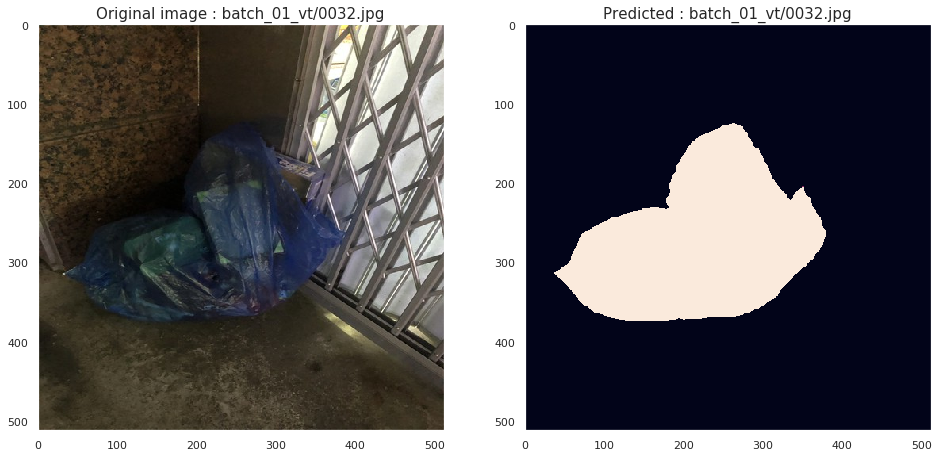

In [ ]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/DeepLabV3_Effb7_dropout03.csv", index=False)

0it [00:00, ?it/s]

Start prediction.


93it [18:51, 12.17s/it]


End prediction.


criterion1(outputs, masks) + criterion2(outputs, masks)## Reference

